# notebook for testing results for different grid hares
Showing progress with new likelihood function, and fixing the `obs_noise' function issue

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_unit import WMSE
from pitchfuncs_unit import InversePCA
from pitchfuncs_unit import emulator
from pitchfuncs_unit import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


2024-05-17 12:48:24.539089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 12:48:24.539117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 12:48:24.539959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 12:48:24.544712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 12:48:25.047938: W tensorflow/compiler/tf2

## 1) import hare and pitchfork

In [2]:
hare = pd.read_json("pickle jar/solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
3806715,0.98,0.013508,0.24,2.1,4.384008,0.938134,0.796204,5633.170928,-0.046555,736.048182,...,0.891185,0.892424,0.893956,0.895084,0.895033,0.896013,0.896049,0.894976,0.892958,-0.378239


In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-05-17 12:48:26.656289: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-17 12:48:26.656311: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-05-17 12:48:26.656316: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-05-17 12:48:26.656403: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-05-17 12:48:26.656422: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-05-17 12:48:26.656426: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


## 2) define priors
this uses the min and max trained ranges stored in the emulator pickle dict

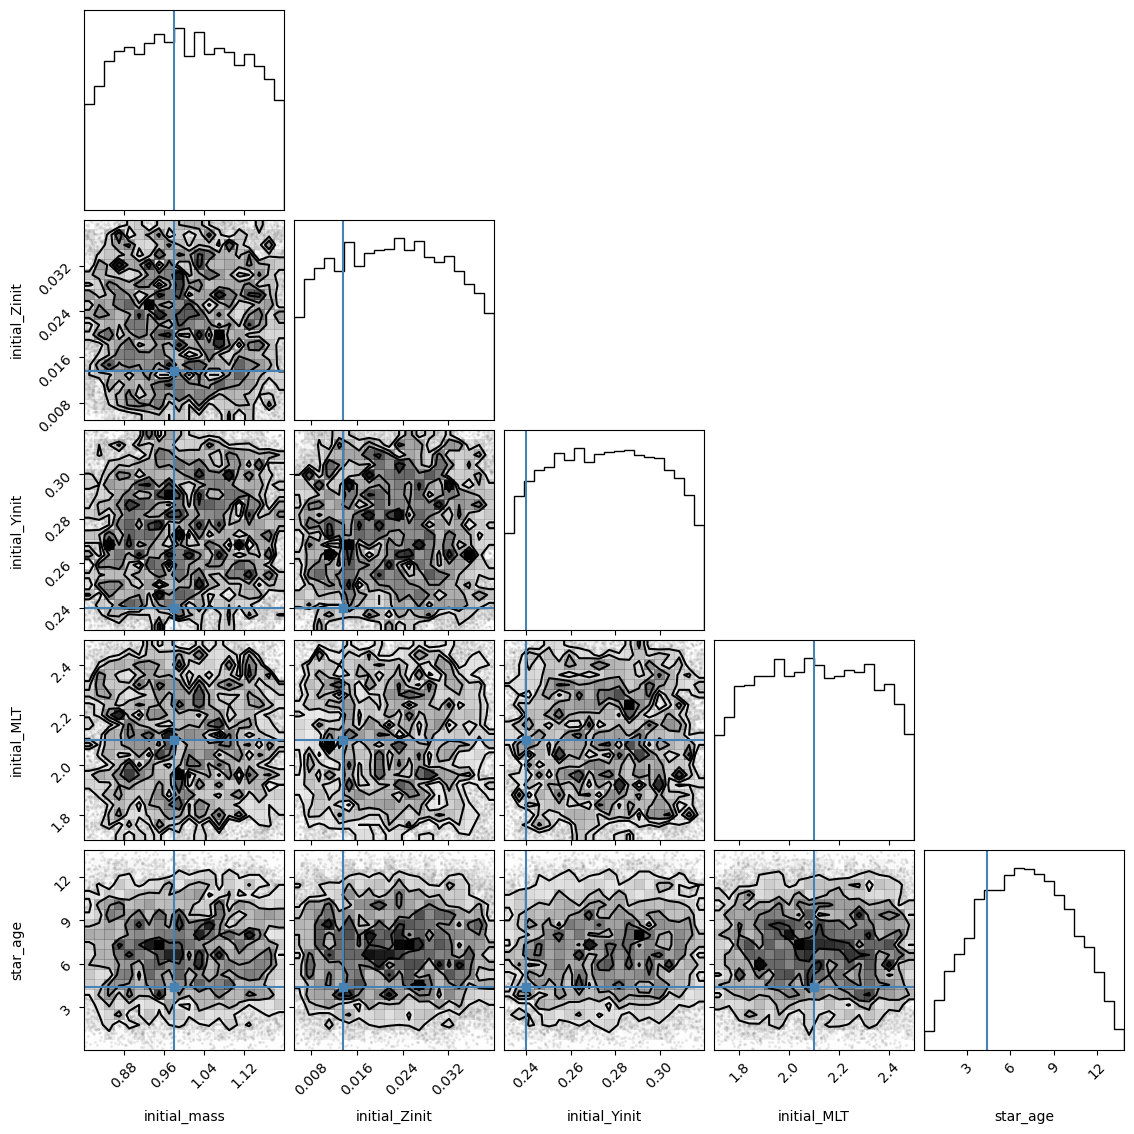

In [4]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

def custom_uniform_prior(prior_min, prior_max):
    return scipy.stats.uniform(loc=prior_min, scale=prior_max-prior_min)

def custom_beta_prior(prior_min, prior_max, a=1, b=1):
    return scipy.stats.beta(loc=prior_min, scale=prior_max-prior_min, a=a, b=b)

mass_prior = custom_beta_prior(0.8, 1.2, a=1.2, b=1.2)

Zinit_prior = custom_beta_prior(0.005, 0.04, a=1.2, b=1.2)

Yinit_prior = custom_beta_prior(0.23, 0.32, a=1.2, b=1.2)

MLT_prior = custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

## Test for n= 6 to 40

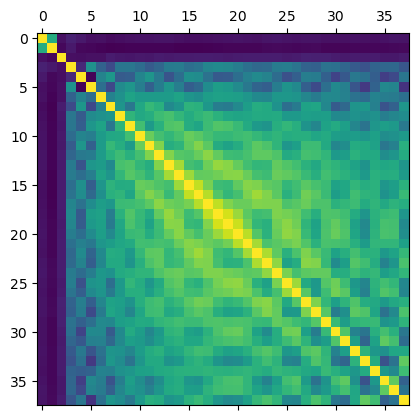

In [6]:
hare = pd.read_json("pickle jar/highZ_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz


obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max+1)])

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

corr = np.corrcoef(emulator_errors.to_numpy().T)
plt.matshow(corr)

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

iter: 4186 | +250 | bound: 87 | nc: 1 | ncall: 91263 | eff(%):  4.874 | loglstar:   -inf < -22.686 <    inf | logz: -38.015 +/-  0.226 | dlogz:  0.001 >  0.259                                       

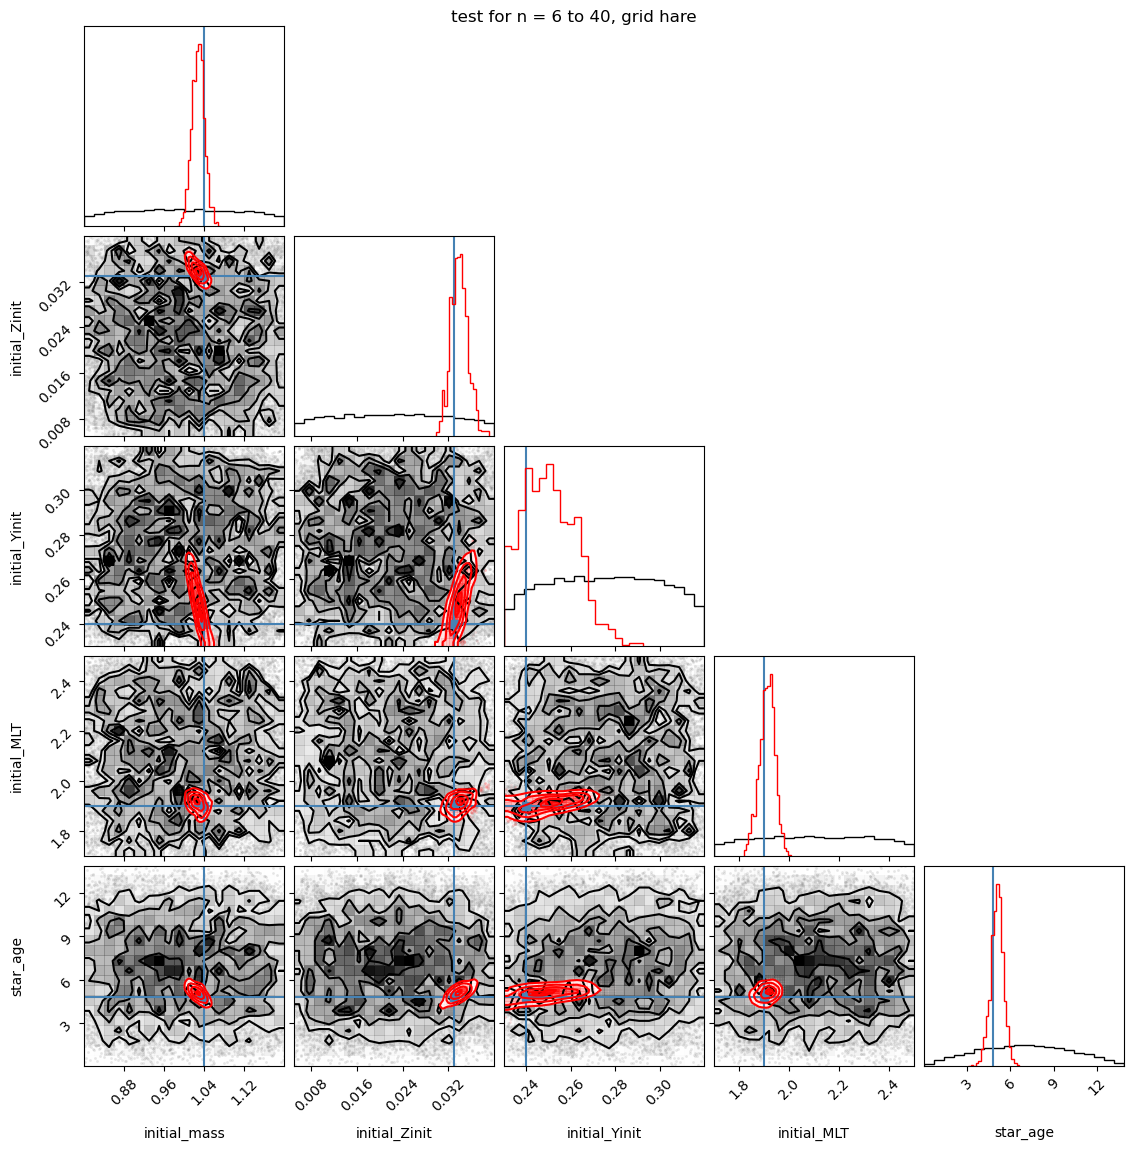

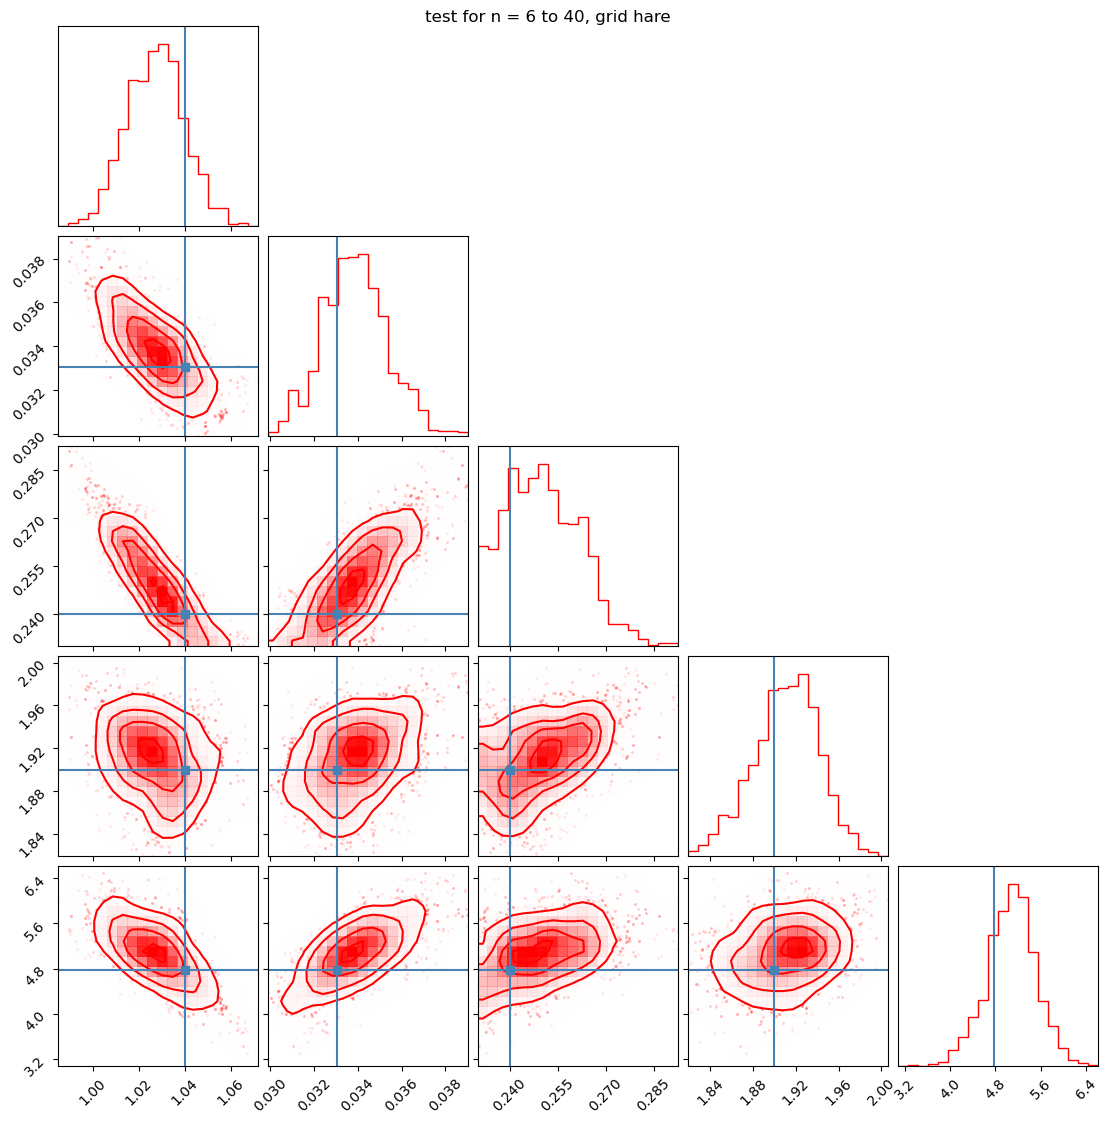

In [7]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_true.values[0], pitchfork=pitchfork, log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True}, smooth=True);
plt.suptitle('test for n = 6 to 40, grid hare')

figure = corner.corner(posterior, labels = inputs, truths = hare_inps.values[0],color='red',hist_kwargs={'density':True}, smooth=True);
plt.suptitle('test for n = 6 to 40, grid hare');

## Test for n= 15 to 25

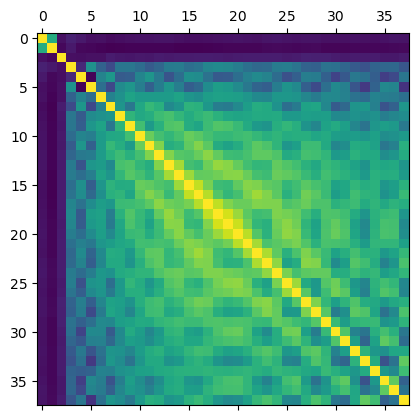

In [9]:
hare = pd.read_json("pickle jar/highZ_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz


obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[1e12 for i in range(n_min,n_max+1)])
obs_unc[12:23] = frequency_unc 

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

corr = np.corrcoef(emulator_errors.to_numpy().T)
plt.matshow(corr)

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

iter: 3200 | +250 | bound: 63 | nc: 1 | ncall: 66194 | eff(%):  5.232 | loglstar:   -inf < -691.410 <    inf | logz: -702.756 +/-  0.201 | dlogz:  0.001 >  0.259                                     

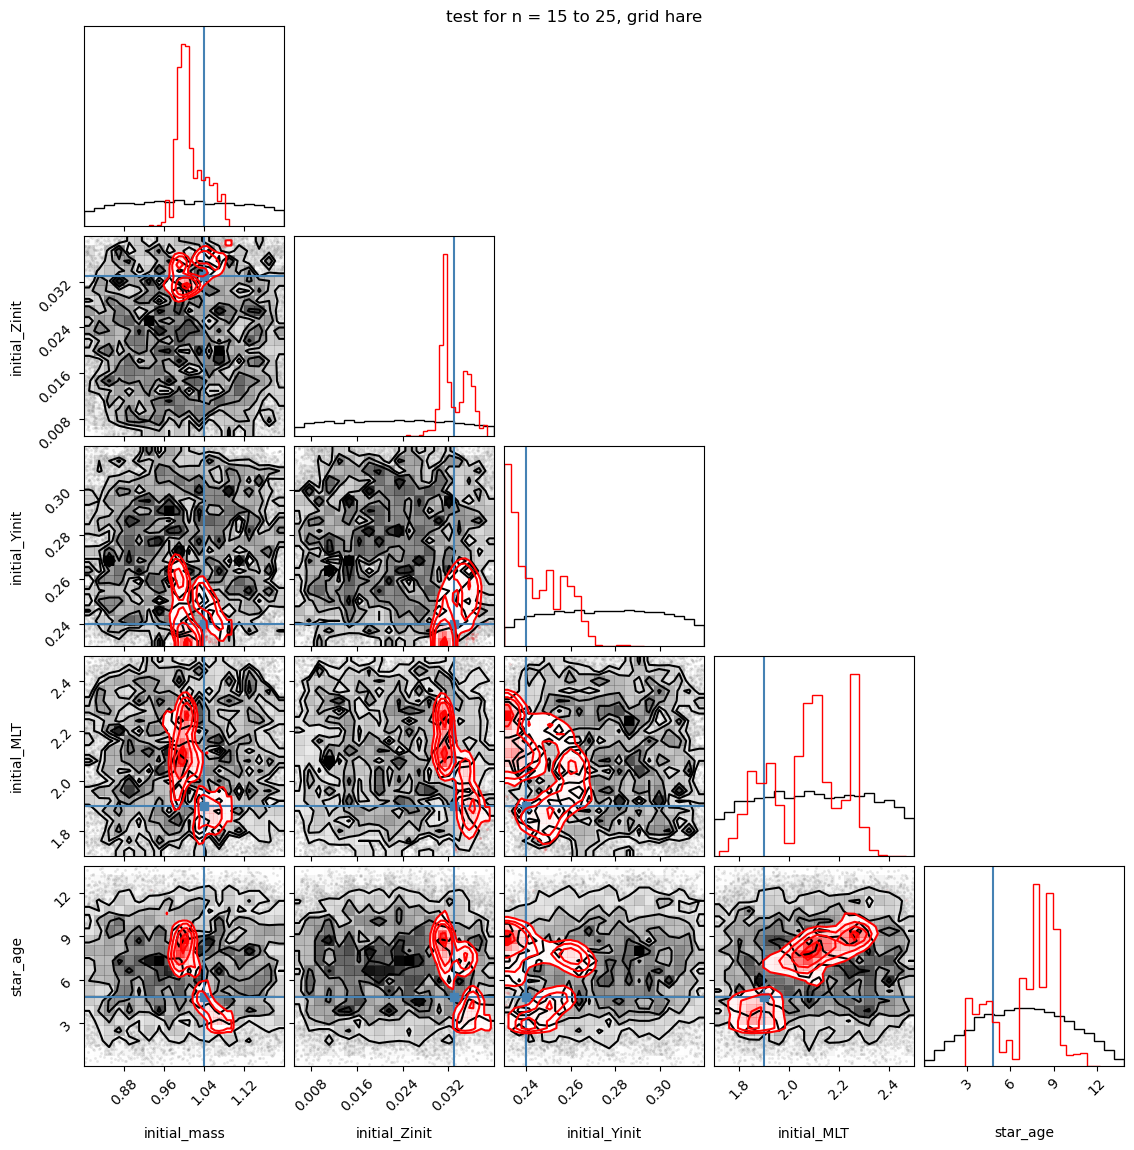

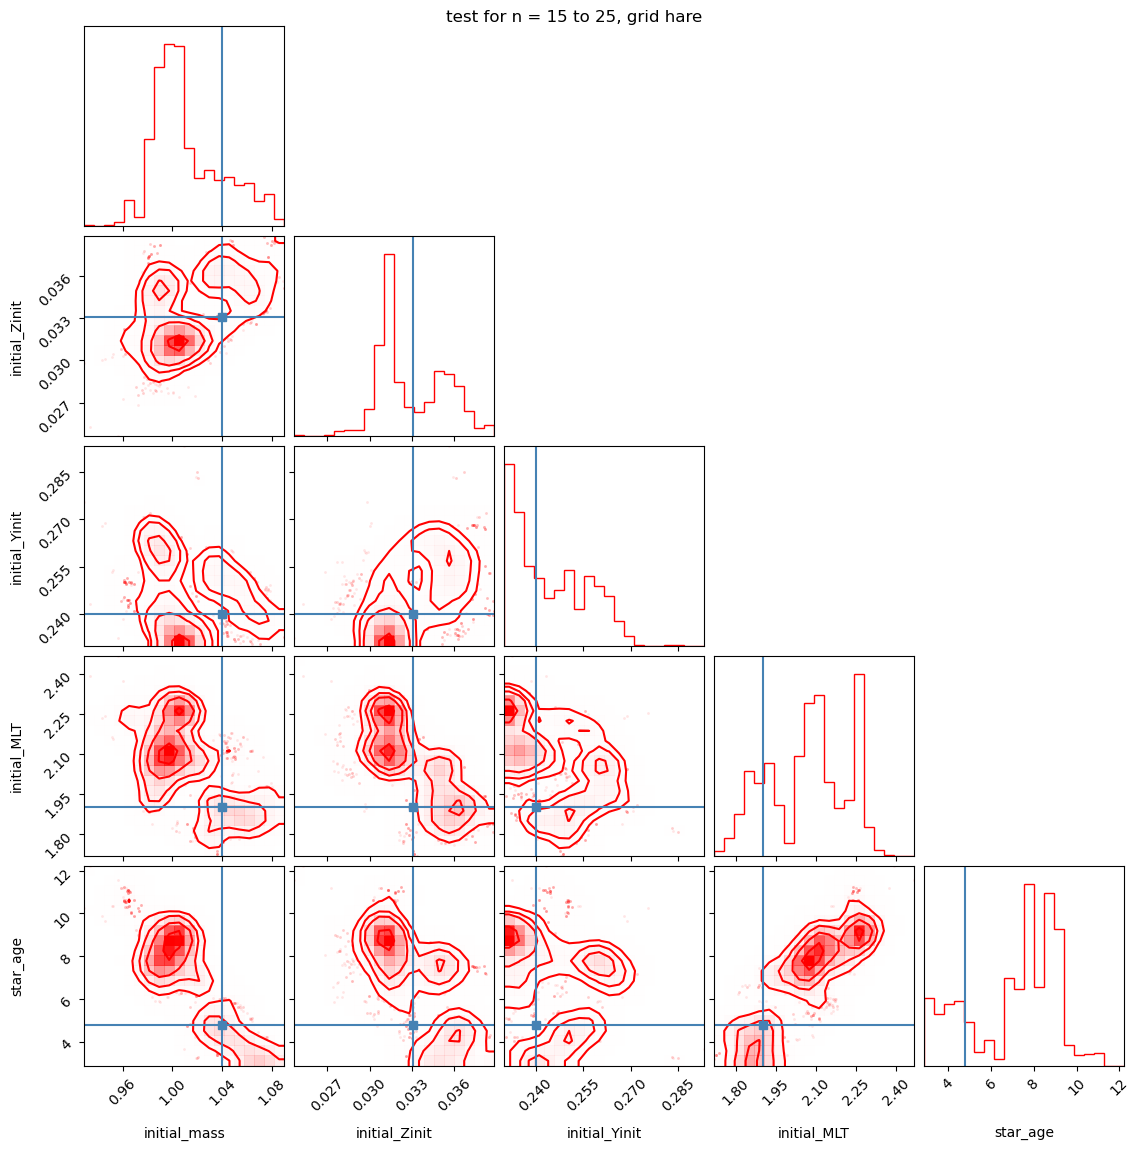

In [10]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_true.values[0], pitchfork=pitchfork, log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
posterior_15_25 = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior_15_25, fig=figure, color='red',hist_kwargs={'density':True}, smooth=True);
plt.suptitle('test for n = 15 to 25, grid hare')

figure = corner.corner(posterior_15_25, labels = inputs, truths = hare_inps.values[0],color='red',hist_kwargs={'density':True}, smooth=True);
plt.suptitle('test for n = 15 to 25, grid hare');